In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import os
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, 
                                     Dropout, RandomRotation,RandomZoom , RandomWidth , RandomHeight , RandomBrightness,
                                     RandomContrast, Rescaling, Resizing, Reshape ,Bidirectional, LSTM)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import backend as k
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam , SGD 
from tensorflow.keras.callbacks import  ReduceLROnPlateau 
from tensorflow.keras.regularizers  import L2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K 
from tensorflow.keras import layers
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install --upgrade pip
!pip install mat73
!pip install natsort

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [4]:
import mat73
train_data = mat73.loadmat("/kaggle/input/street-view-house-numbers/train_digitStruct.mat")

In [5]:
labels=[]
for item in train_data['digitStruct']['bbox']:
    labels.append(item['label'])

In [6]:
train_path = os.listdir("/kaggle/input/street-view-house-numbers/train/train")
train_path[:5]

['27147.png', '32352.png', '21130.png', '22897.png', '9273.png']

In [7]:
from natsort import natsorted
train_path = natsorted(train_path)
print(train_path[-5:])

['33399.png', '33400.png', '33401.png', '33402.png', 'see_bboxes.m']


In [8]:
train_path = ["/kaggle/input/street-view-house-numbers/train/train/"+str(i) for i in train_path]

In [9]:
train_path=train_path[:-1]

In [10]:
print(len(train_path) , len(labels))

33402 33402


In [11]:
Dataframe = pd.DataFrame({"img_path" : train_path ,'label': labels})

In [12]:
Dataframe.head()

img_path       label
0  /kaggle/input/street-view-house-numbers/train/...  [1.0, 9.0]
1  /kaggle/input/street-view-house-numbers/train/...  [2.0, 3.0]
2  /kaggle/input/street-view-house-numbers/train/...  [2.0, 5.0]
3  /kaggle/input/street-view-house-numbers/train/...  [9.0, 3.0]
4  /kaggle/input/street-view-house-numbers/train/...  [3.0, 1.0]

In [13]:
def convert_to_list(value):
    if not isinstance(value, list):
        return [value]
    return value

In [14]:
Dataframe["label"] = Dataframe["label"].apply(convert_to_list)

In [15]:
max_label_len = max([len(text) for text in Dataframe["label"]])
max_label_len

6

In [16]:
def train_img_labls(dataframe):
    images = []
    labels = []
    for _,row in dataframe.iterrows():
        img = cv2.imread(str(row["img_path"]))
        img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img , (128,32))
        label = row["label"]
        label = [int(item)%10 for item in label]
        images.append(img)
        labels.append(label)
    return images , labels

In [17]:
images , labels = train_img_labls(Dataframe)

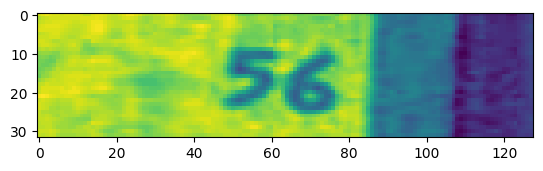

In [18]:
plt.imshow(images[1099])

In [19]:
labels[1099]

[5, 6]

In [20]:
char_list =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

labels = [pad_sequences([label], maxlen=6, padding='post' ,value = len(char_list))[0] for label in labels]

In [21]:
labels[1]

array([ 2,  3, 62, 62, 62, 62], dtype=int32)

In [22]:
def process_single_sample(img, label):
    return {"image": img, "label": label}

In [23]:
input_output_pairs = (images,labels)
dataset = tf.data.Dataset.from_tensor_slices(input_output_pairs)

In [24]:
def split(dataset, TRAIN_RATIO, VAL_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset, val_dataset

In [25]:
TRAIN_RATIO = 0.9
VAL_RATIO = 0.1

train_dataset, val_dataset = split(dataset, TRAIN_RATIO, VAL_RATIO)

In [26]:
batch_size = 64  # Adjust as needed
train_dataset = (train_dataset
                 .map(process_single_sample)
                 .shuffle(buffer_size=1000)
                 .batch(batch_size))
val_dataset = (val_dataset
                 .map(process_single_sample)
                 .shuffle(buffer_size=100)
                 .batch(batch_size))

In [27]:
train_dataset

<_BatchDataset element_spec={'image': TensorSpec(shape=(None, 32, 128), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None, 6), dtype=tf.int32, name=None)}>

In [28]:
val_dataset

<_BatchDataset element_spec={'image': TensorSpec(shape=(None, 32, 128), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None, 6), dtype=tf.int32, name=None)}>

In [29]:
from itertools import groupby
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [30]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = val_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()

        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

In [31]:
class CTCLayer(layers.Layer):


    def __init__(self, name=None):


        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost


    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.


        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")


        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")


        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)


        # At test time, just return the computed predictions
        return y_pred




In [39]:
def train(epochs):
    
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "relu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "relu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "relu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "relu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "relu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "relu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(11, (2,2), activation = "relu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(63, activation = 'softmax', name="dense")(blstm_2)
    
    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    optimizer = Adam(lr=0.0001, beta_1=0.7, beta_2=0.399, clipnorm=1.0)

    #model to be used at training time
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer)

    print(model.summary())
    file_path = "C_LSTM_best.hdf5"
    callbacks_list = [PlotPredictions(frequency=1)]

    history = model.fit(train_dataset, 
                        epochs = epochs,
                        validation_data=val_dataset,
                        callbacks = callbacks_list,
                        verbose = 1,
                        shuffle=True)
    
    return model

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 32, 128, 32)          320       ['image[0][0]']               
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 16, 64, 32)           0         ['conv2d_21[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 16, 64, 64)           18496     ['max_pooling2d_12[0][0

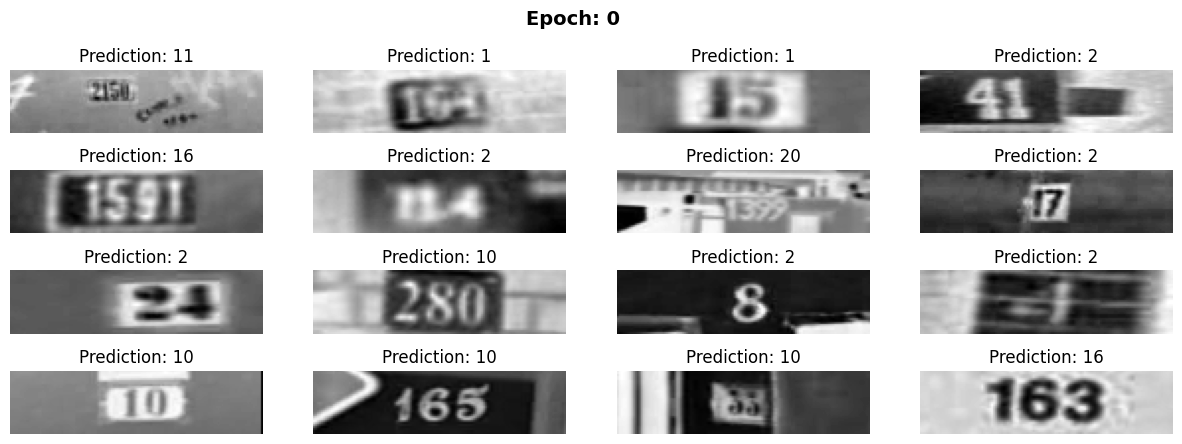

470/470 [==============================] - 39s 62ms/step - loss: 6.3639 - val_loss: 5.6608
Epoch 2/20
2/2 [==============================] - 2s 7ms/step - loss: 4.85


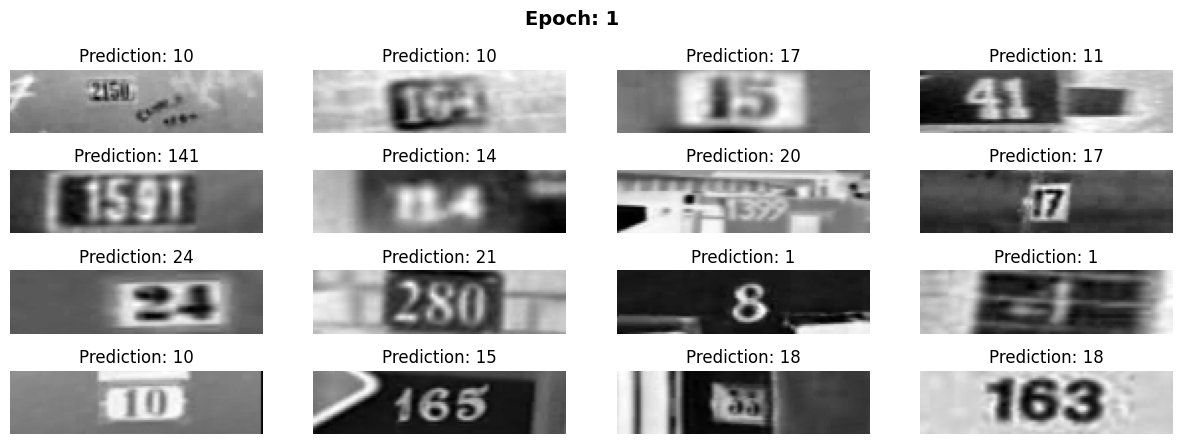

470/470 [==============================] - 26s 55ms/step - loss: 4.8591 - val_loss: 4.7628
Epoch 3/20
2/2 [==============================] - 1s 8ms/step - loss: 3.12


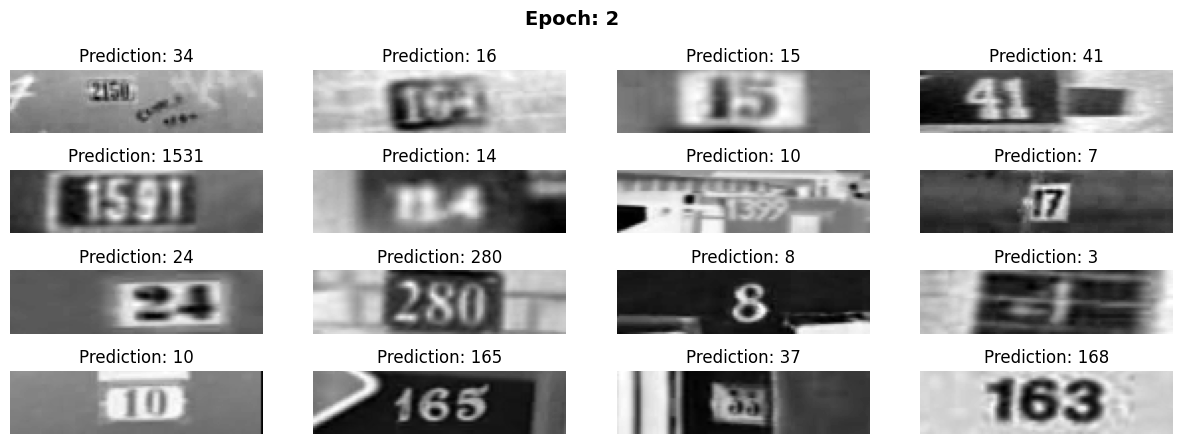

470/470 [==============================] - 25s 54ms/step - loss: 3.1243 - val_loss: 2.8979
Epoch 4/20
2/2 [==============================] - 1s 7ms/step - loss: 2.23


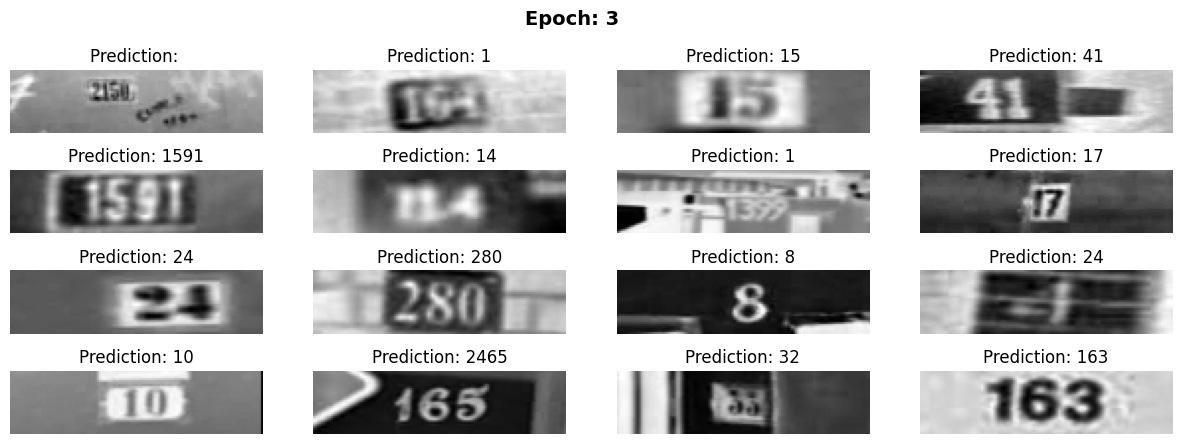

470/470 [==============================] - 26s 54ms/step - loss: 2.2342 - val_loss: 2.1059
Epoch 5/20
2/2 [==============================] - 1s 8ms/step - loss: 1.89


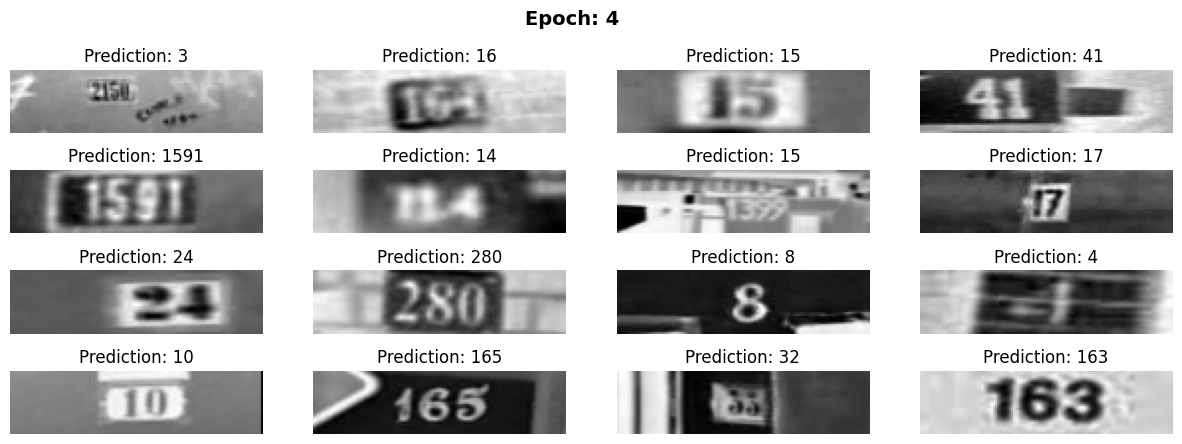

470/470 [==============================] - 26s 54ms/step - loss: 1.8927 - val_loss: 1.8721
Epoch 6/20
2/2 [==============================] - 1s 7ms/step - loss: 1.68


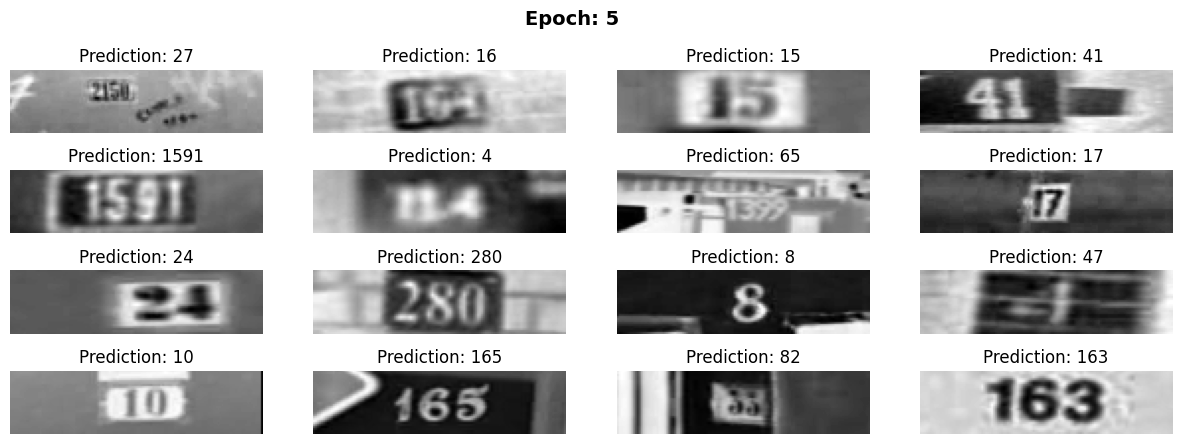

470/470 [==============================] - 25s 54ms/step - loss: 1.6815 - val_loss: 1.8387
Epoch 7/20
2/2 [==============================] - 1s 12ms/step- loss: 1.53


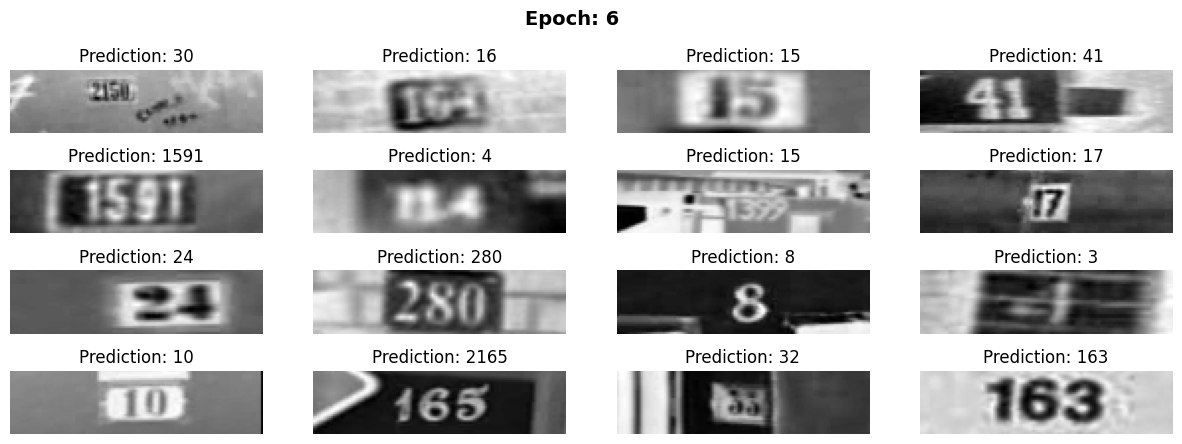

470/470 [==============================] - 26s 54ms/step - loss: 1.5339 - val_loss: 1.8053
Epoch 8/20
2/2 [==============================] - 1s 7ms/step - loss: 1.40


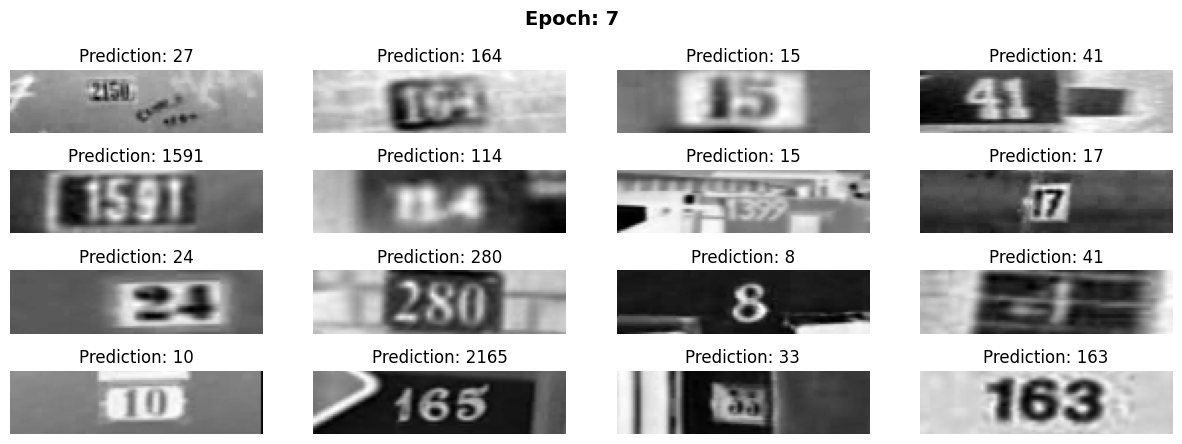

470/470 [==============================] - 25s 54ms/step - loss: 1.4065 - val_loss: 1.7653
Epoch 9/20
2/2 [==============================] - 1s 8ms/step - loss: 1.29


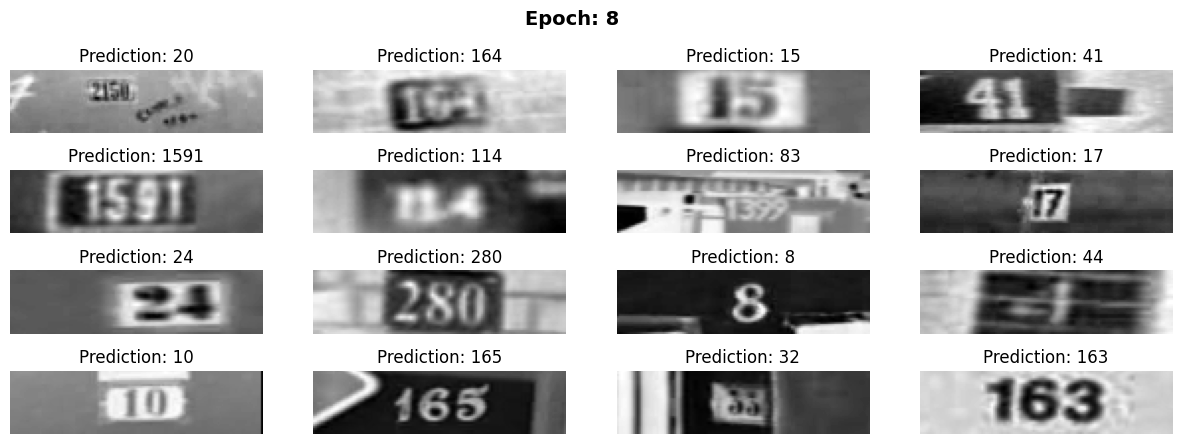

470/470 [==============================] - 26s 54ms/step - loss: 1.2947 - val_loss: 1.6175
Epoch 10/20
2/2 [==============================] - 1s 7ms/step - loss: 1.20


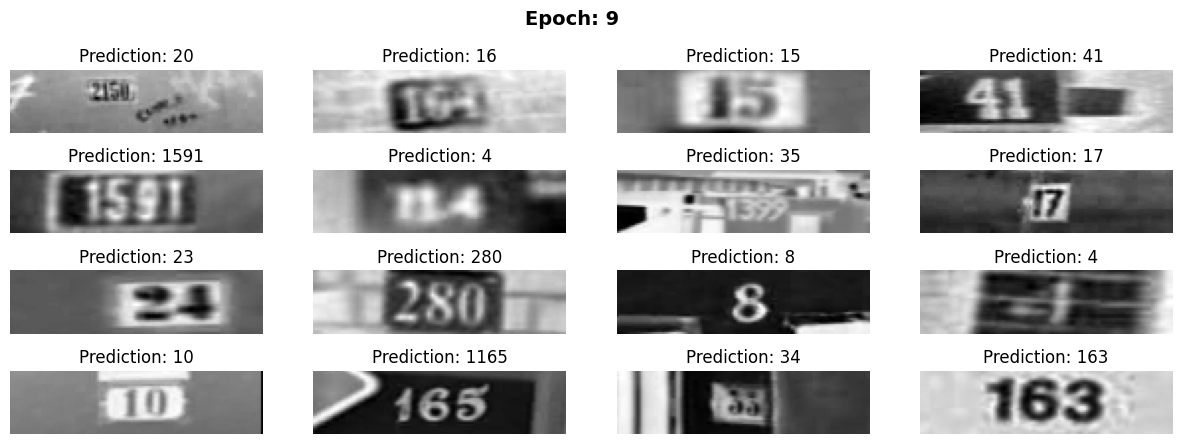

470/470 [==============================] - 25s 54ms/step - loss: 1.2086 - val_loss: 1.6722
Epoch 11/20
2/2 [==============================] - 1s 7ms/step - loss: 1.12


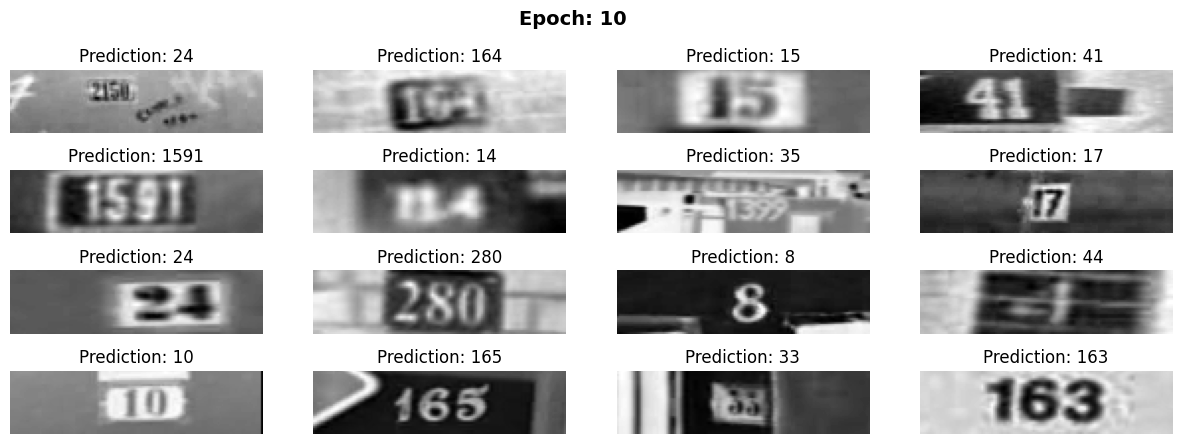

470/470 [==============================] - 26s 55ms/step - loss: 1.1277 - val_loss: 1.8192
Epoch 12/20
2/2 [==============================] - 1s 7ms/step - loss: 1.05


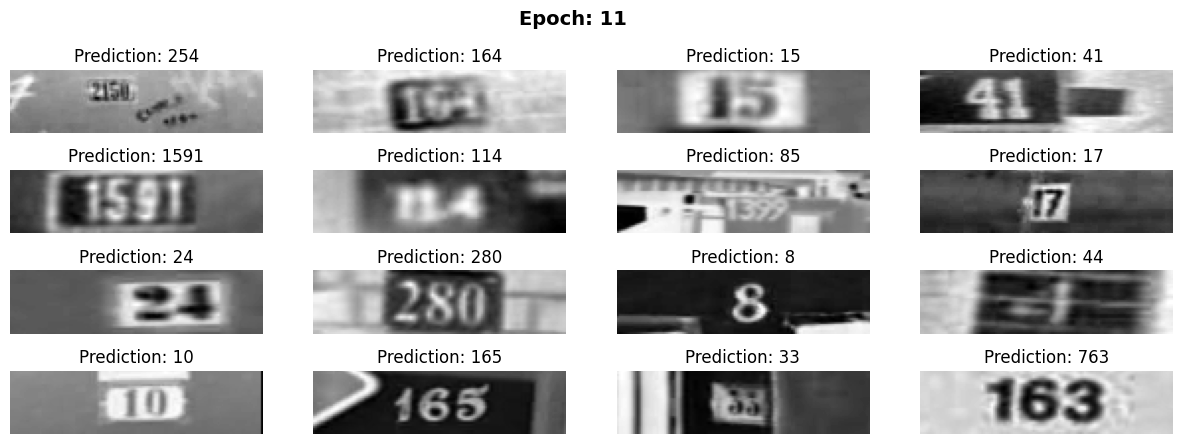

470/470 [==============================] - 25s 54ms/step - loss: 1.0578 - val_loss: 1.6305
Epoch 13/20
2/2 [==============================] - 1s 7ms/step - loss: 0.99


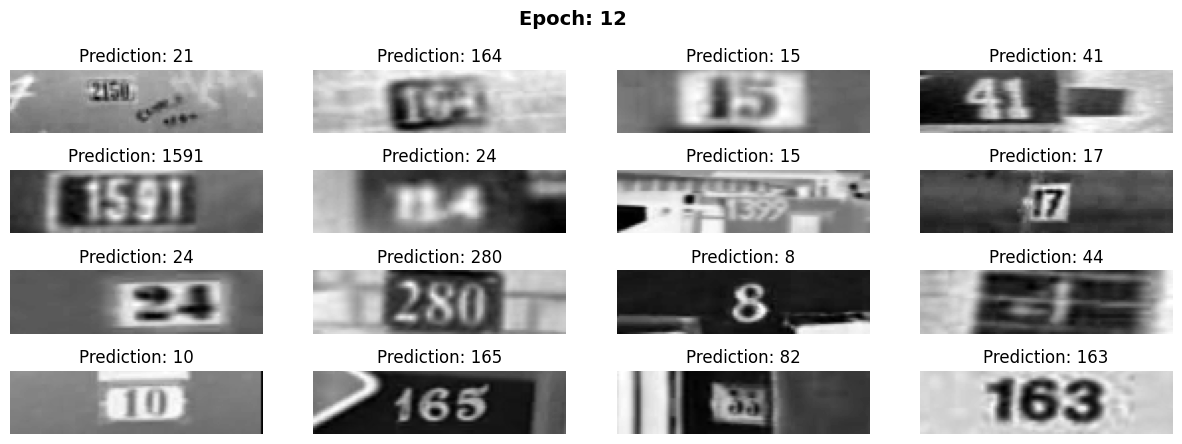

470/470 [==============================] - 25s 54ms/step - loss: 0.9945 - val_loss: 1.4634
Epoch 14/20
2/2 [==============================] - 1s 7ms/step - loss: 0.92


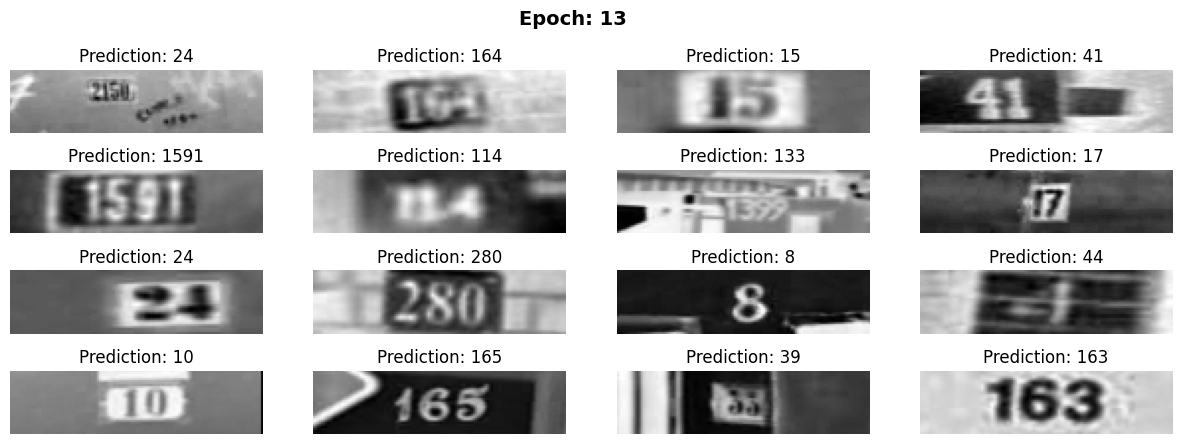

470/470 [==============================] - 25s 54ms/step - loss: 0.9288 - val_loss: 1.5566
Epoch 15/20
2/2 [==============================] - 1s 8ms/step - loss: 0.88


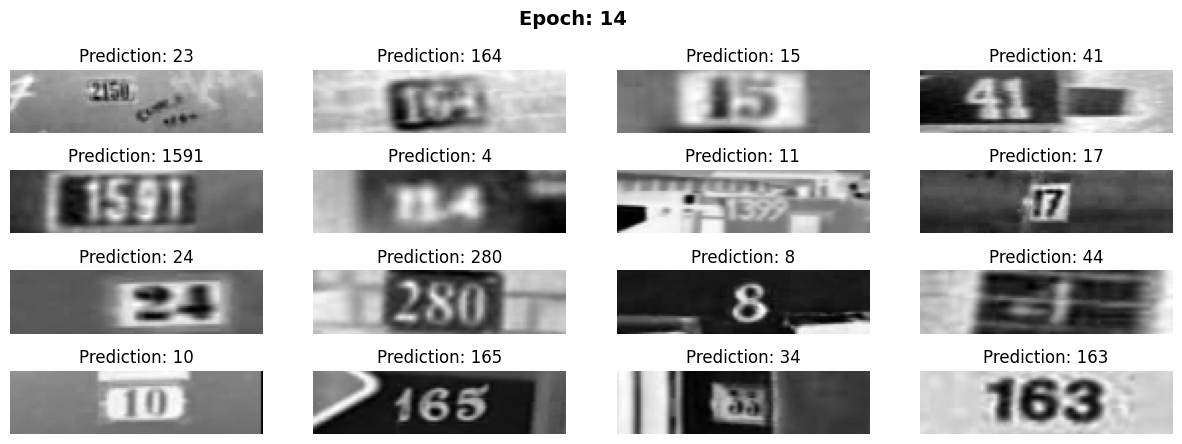

470/470 [==============================] - 27s 58ms/step - loss: 0.8820 - val_loss: 1.7558
Epoch 16/20
2/2 [==============================] - 2s 7ms/step - loss: 0.82


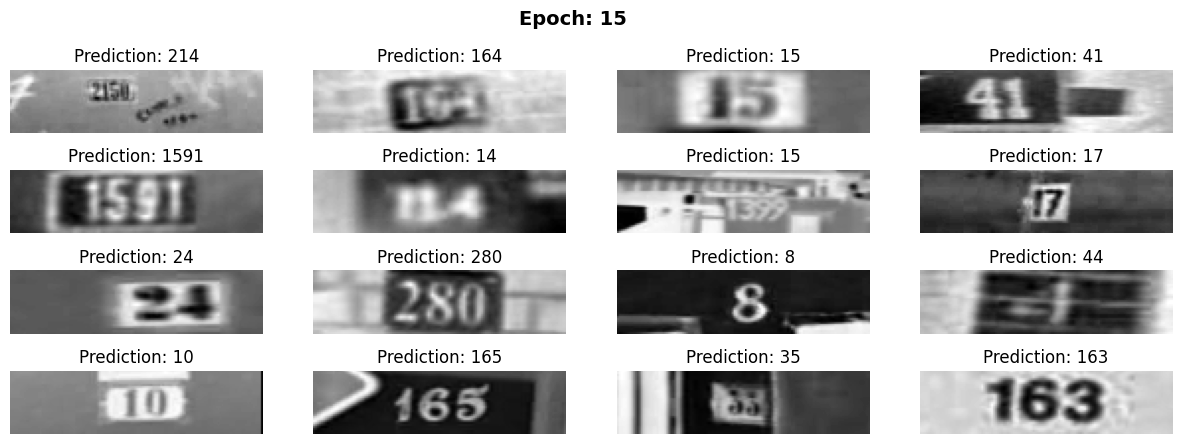

470/470 [==============================] - 26s 55ms/step - loss: 0.8283 - val_loss: 1.5755
Epoch 17/20
2/2 [==============================] - 1s 7ms/step - loss: 0.78


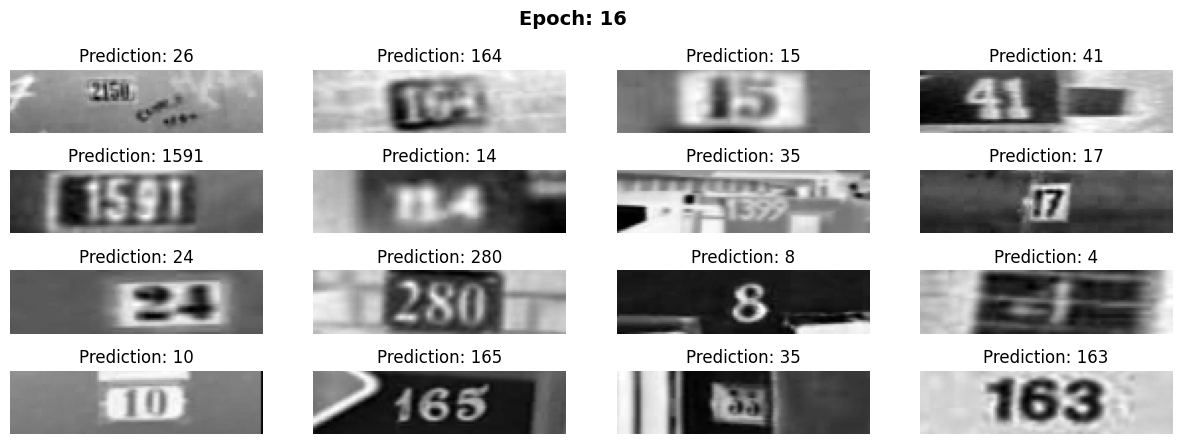

470/470 [==============================] - 26s 54ms/step - loss: 0.7849 - val_loss: 1.6113
Epoch 18/20
2/2 [==============================] - 1s 7ms/step - loss: 0.74


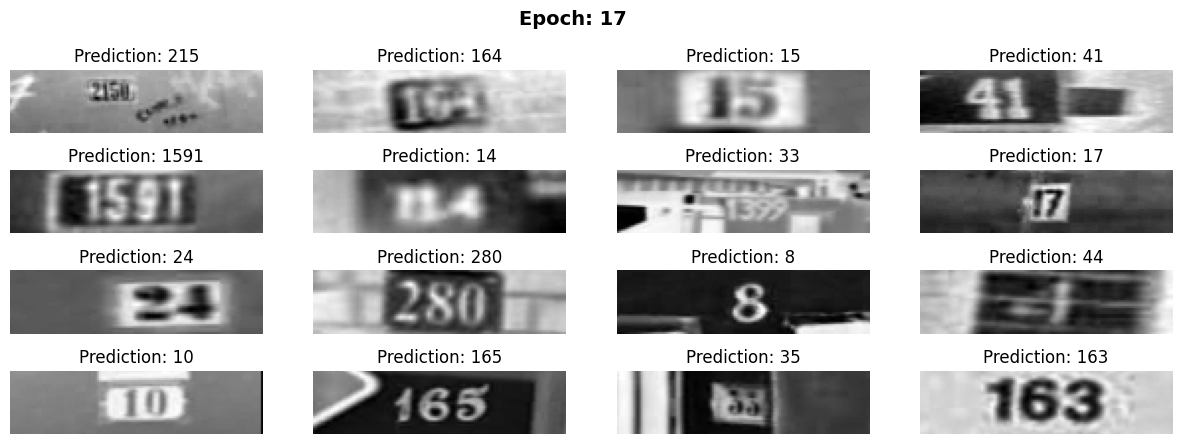

470/470 [==============================] - 26s 54ms/step - loss: 0.7419 - val_loss: 1.6766
Epoch 19/20
2/2 [==============================] - 1s 7ms/step - loss: 0.70


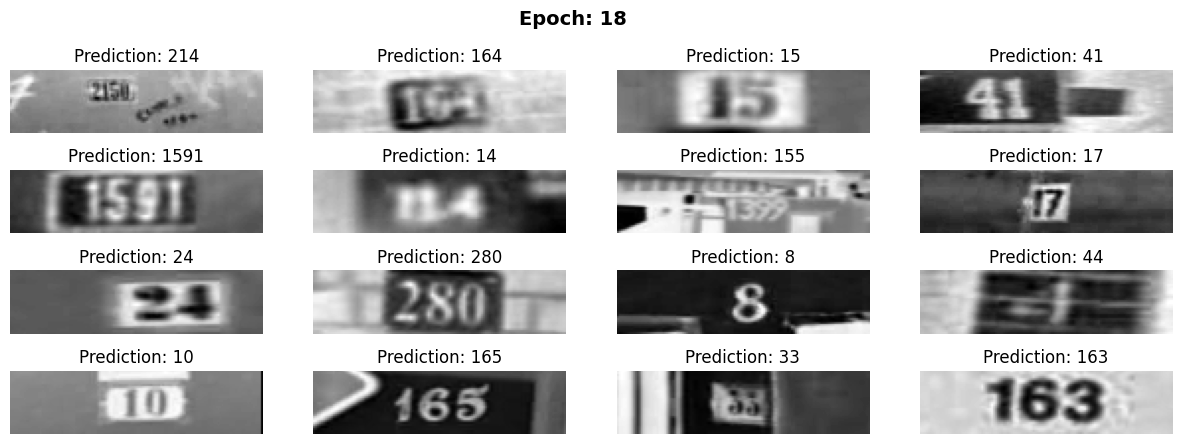

470/470 [==============================] - 25s 54ms/step - loss: 0.7056 - val_loss: 1.7258
Epoch 20/20
2/2 [==============================] - 1s 7ms/step - loss: 0.66


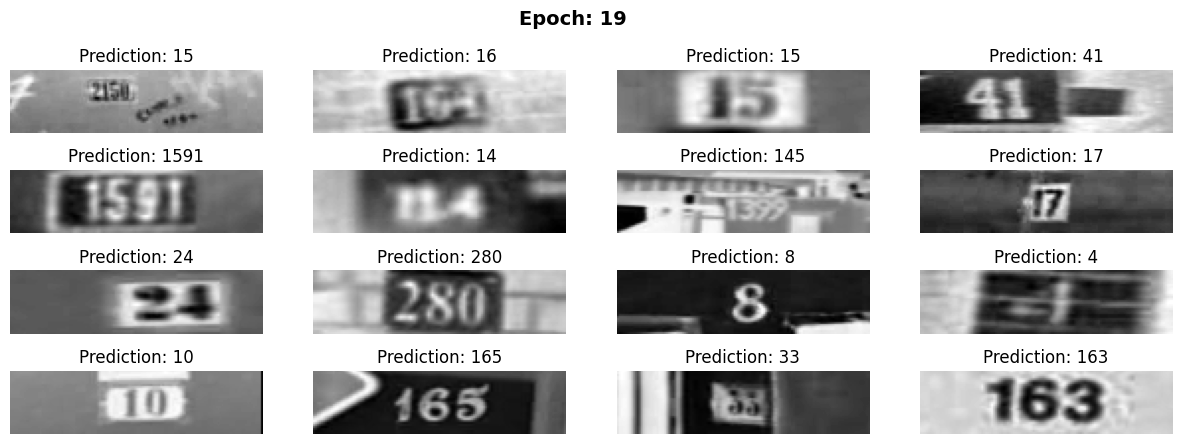

470/470 [==============================] - 25s 54ms/step - loss: 0.6617 - val_loss: 1.7786


In [40]:
model = train(20)